In [ ]:
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
%matplotlib inline
import warnings                   
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/sample_data/daily-website-visitors.csv")

df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '')
df['Count'] = df['Page.Loads'].astype(str).astype(int)
df = df[['Date', 'Day', 'Count']]
df.set_index('Date', inplace=True)

In [ ]:
# take data upto 12/31/2019
df = df[df.index <= '12/31/2019']

# drop first three data as we want len(df) % 7 = 0 for weekly data
# df.drop(df.head(3).index, inplace = True)

# we now have 276 weeks: to make it pretty, let's take a whole 270 weeks and make 90-10 split.
# df.drop(df.head(6*7).index, inplace = True)

In [ ]:
df.shape

(1935, 2)

In [ ]:
df1=df.reset_index()['Count']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# splitting dataset into train and test split
training_size=int(len(df1) * 0.9)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(1741, 194)

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   # for i=0, datax = [0,1,2,3-----99], datay = 100 
		dataX.append(a)
		dataY.append([dataset[i + time_step, 0]]) # !!!!! MADE A CHANGE HERE !!!!!
	return numpy.array(dataX), numpy.array(dataY)

###### MADE A CHANGE ABOVE ⏫

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, ytest.shape

((1640, 100), (1640, 1), (93, 100), (93, 1))

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1) # validation_data=(X_test,ytest)

Epoch 1/100
26/26 [==============================] - 11s 187ms/step - loss: 0.0624
Epoch 2/100
26/26 [==============================] - 5s 186ms/step - loss: 0.0302
Epoch 3/100
26/26 [==============================] - 5s 185ms/step - loss: 0.0290
Epoch 4/100
26/26 [==============================] - 5s 183ms/step - loss: 0.0279
Epoch 5/100
26/26 [==============================] - 5s 183ms/step - loss: 0.0267
Epoch 6/100
26/26 [==============================] - 5s 200ms/step - loss: 0.0266
Epoch 7/100
26/26 [==============================] - 5s 184ms/step - loss: 0.0258
Epoch 8/100
26/26 [==============================] - 5s 182ms/step - loss: 0.0251
Epoch 9/100
26/26 [==============================] - 5s 195ms/step - loss: 0.0245
Epoch 10/100
26/26 [==============================] - 5s 183ms/step - loss: 0.0243
Epoch 11/100
26/26 [==============================] - 5s 182ms/step - loss: 0.0241
Epoch 12/100
26/26 [==============================] - 5s 180ms/step - loss: 0.0238
Epoch 13/100

In [ ]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# Transformback to original form
y_train=scaler.inverse_transform(y_train)
ytest=scaler.inverse_transform(ytest)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
y_train[0], train_predict[0], ytest[0], test_predict[0]

(array([2298.]),
 array([2374.1226], dtype=float32),
 array([4076.]),
 array([3491.784], dtype=float32))

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
# math.sqrt(mean_squared_error(y_train,train_predict))

mse = mean_squared_error(ytest,test_predict)
rmse = math.sqrt(mse)
nrmse = rmse / (max(df['Count']) - min(df['Count']))
print("mse=",mse,"\t\trmse=",rmse,"\tnrmse=",nrmse)

mse= 23879761.987528097 		rmse= 4886.692336082567 	nrmse= 0.6998986445262915


In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

416.61857453594286

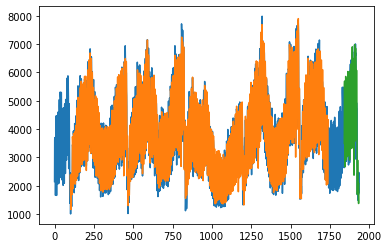

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()